In [2]:
import io
import requests
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv("AAPL2.csv", sep=',')
print (df)

            Date        Open        High         Low       Close   Adj Close  \
0     2016-06-29   23.492500   23.637501   23.407499   23.600000   22.013783   
1     2016-06-30   23.610001   23.942499   23.575001   23.900000   22.293617   
2     2016-07-01   23.872499   24.117500   23.832500   23.972500   22.361248   
3     2016-07-05   23.847500   23.850000   23.615000   23.747499   22.151365   
4     2016-07-06   23.650000   23.915001   23.592501   23.882500   22.277292   
...          ...         ...         ...         ...         ...         ...   
1247  2021-06-14  127.820000  130.539993  127.070000  130.479996  130.284790   
1248  2021-06-15  129.940002  130.600006  129.389999  129.639999  129.446060   
1249  2021-06-16  130.369995  130.889999  128.460007  130.149994  129.955292   
1250  2021-06-17  129.800003  132.550003  129.649994  131.789993  131.592834   
1251  2021-06-18  130.710007  131.509995  130.240005  130.460007  130.264832   

         Volume  
0     146124000  
1  

In [6]:
def ADX(df: pd.DataFrame(), interval: int=14):
  df['-DM'] = df['Low'].shift(1) - df['Low']
  df['+DM'] = df['High'] - df['High'].shift(1)
  df['+DM'] = np.where((df['+DM'] > df['-DM']) & (df['+DM']>0), df['+DM'], 0.0)
  df['-DM'] = np.where((df['-DM'] > df['+DM']) & (df['-DM']>0), df['-DM'], 0.0)
  df['TR_TMP1'] = df['High'] - df['Low']
  df['TR_TMP2'] = np.abs(df['High'] - df['Adj Close'].shift(1))
  df['TR_TMP3'] = np.abs(df['Low'] - df['Adj Close'].shift(1))
  df['TR'] = df[['TR_TMP1', 'TR_TMP2', 'TR_TMP3']].max(axis=1)
  df['TR'+str(interval)] = df['TR'].rolling(interval).sum()
  df['+DMI'+str(interval)] = df['+DM'].rolling(interval).sum()
  df['-DMI'+str(interval)] = df['-DM'].rolling(interval).sum()
  df['+DI'+str(interval)] = df['+DMI'+str(interval)] /   df['TR'+str(interval)]*100
  df['-DI'+str(interval)] = df['-DMI'+str(interval)] / df['TR'+str(interval)]*100
  df['DI'+str(interval)+'-'] = abs(df['+DI'+str(interval)] - df['-DI'+str(interval)])
  df['DI'+str(interval)] = df['+DI'+str(interval)] + df['-DI'+str(interval)]
  df['DX'] = (df['DI'+str(interval)+'-'] / df['DI'+str(interval)])*100
  df['ADX'+str(interval)] = df['DX'].rolling(interval).mean()
  df['ADX'+str(interval)] =   df['ADX'+str(interval)].fillna(df['ADX'+str(interval)].mean())
  del df['TR_TMP1'], df['TR_TMP2'], df['TR_TMP3'], df['TR'], df['TR'+str(interval)]
  del df['+DMI'+str(interval)], df['DI'+str(interval)+'-']
  del df['DI'+str(interval)], df['-DMI'+str(interval)]
  del df['+DI'+str(interval)], df['-DI'+str(interval)]
  del df['DX']
  return df

            Date        Open        High         Low       Close   Adj Close  \
0     2016-06-29   23.492500   23.637501   23.407499   23.600000   22.013783   
1     2016-06-30   23.610001   23.942499   23.575001   23.900000   22.293617   
2     2016-07-01   23.872499   24.117500   23.832500   23.972500   22.361248   
3     2016-07-05   23.847500   23.850000   23.615000   23.747499   22.151365   
4     2016-07-06   23.650000   23.915001   23.592501   23.882500   22.277292   
...          ...         ...         ...         ...         ...         ...   
1247  2021-06-14  127.820000  130.539993  127.070000  130.479996  130.284790   
1248  2021-06-15  129.940002  130.600006  129.389999  129.639999  129.446060   
1249  2021-06-16  130.369995  130.889999  128.460007  130.149994  129.955292   
1250  2021-06-17  129.800003  132.550003  129.649994  131.789993  131.592834   
1251  2021-06-18  130.710007  131.509995  130.240005  130.460007  130.264832   

         Volume        avg       -DM   

<AxesSubplot:>

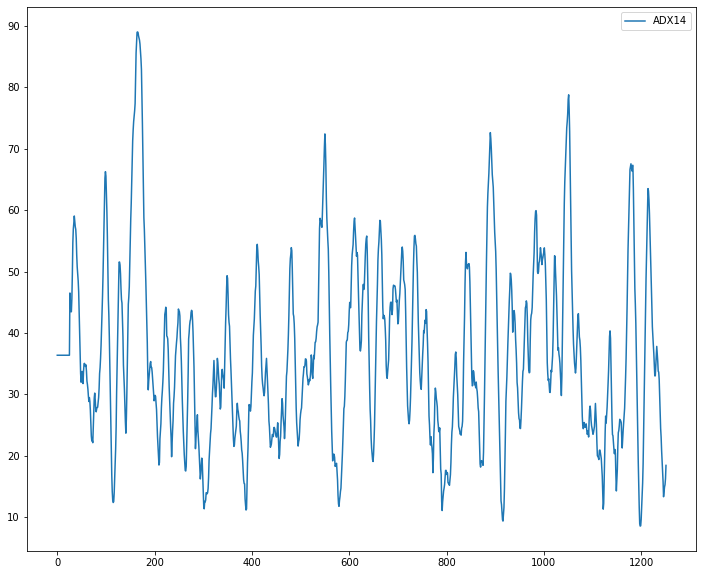

In [29]:
df_adx = ADX(df, 14)
print(df_adx)
df[['ADX14']].plot(figsize=(12,10))

In [14]:
def ADX2(df):

    def getCDM(df):
        dmpos = df["High"][-1] - df["High"][-2]
        dmneg = df["Low"][-2] - df["Low"][-1]
        if dmpos > dmneg:
            return dmpos
        else:
            return dmneg 

    def getDMnTR(df):
        DMpos = []
        DMneg = []
        TRarr = []
        n = round(len(df)/14)
        idx = n
        while n <= (len(df)):
            dmpos = df["High"][n-1] - df["High"][n-2]
            dmneg = df["Low"][n-2] - df["Low"][n-1]
                
            DMpos.append(dmpos)
            DMneg.append(dmneg)
        
            a1 = df["High"][n-1] - df["High"][n-2]
            a2 = df["High"][n-1] - df["Close"][n-2]
            a3 = df["Low"][n-1] - df["Close"][n-2]
            TRarr.append(max(a1,a2,a3))

            n = idx + n
    
        return DMpos, DMneg, TRarr

    def getDI(df):
        DMpos, DMneg, TR = getDMnTR(df)
        CDM = getCDM(df)
        POSsmooth = (sum(DMpos) - sum(DMpos)/len(DMpos) + CDM)
        NEGsmooth = (sum(DMneg) - sum(DMneg)/len(DMneg) + CDM)
        
        DIpos = (POSsmooth / (sum(TR)/len(TR))) *100
        DIneg = (NEGsmooth / (sum(TR)/len(TR))) *100

        return DIpos, DIneg

    def getADX(df):
        DIpos, DIneg = getDI(df)

        dx = (abs(DIpos- DIneg) / abs(DIpos + DIneg)) * 100
        
       
        ADX = dx/14
        return ADX

    result = getADX(df)

# print(ADX(df))

In [15]:
ADX2(df)

KeyError: -1

In [17]:
df2 = pd.read_csv("AAPL2.csv", sep=',')
print (df2)

            Date        Open        High         Low       Close   Adj Close  \
0     2016-06-29   23.492500   23.637501   23.407499   23.600000   22.013783   
1     2016-06-30   23.610001   23.942499   23.575001   23.900000   22.293617   
2     2016-07-01   23.872499   24.117500   23.832500   23.972500   22.361248   
3     2016-07-05   23.847500   23.850000   23.615000   23.747499   22.151365   
4     2016-07-06   23.650000   23.915001   23.592501   23.882500   22.277292   
...          ...         ...         ...         ...         ...         ...   
1247  2021-06-14  127.820000  130.539993  127.070000  130.479996  130.284790   
1248  2021-06-15  129.940002  130.600006  129.389999  129.639999  129.446060   
1249  2021-06-16  130.369995  130.889999  128.460007  130.149994  129.955292   
1250  2021-06-17  129.800003  132.550003  129.649994  131.789993  131.592834   
1251  2021-06-18  130.710007  131.509995  130.240005  130.460007  130.264832   

         Volume  
0     146124000  
1  

In [18]:
aapl=df2
aapl

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-06-29,23.492500,23.637501,23.407499,23.600000,22.013783,146124000
1,2016-06-30,23.610001,23.942499,23.575001,23.900000,22.293617,143345600
2,2016-07-01,23.872499,24.117500,23.832500,23.972500,22.361248,104106000
3,2016-07-05,23.847500,23.850000,23.615000,23.747499,22.151365,110820800
4,2016-07-06,23.650000,23.915001,23.592501,23.882500,22.277292,123796400
...,...,...,...,...,...,...,...
1247,2021-06-14,127.820000,130.539993,127.070000,130.479996,130.284790,96906500
1248,2021-06-15,129.940002,130.600006,129.389999,129.639999,129.446060,62746300
1249,2021-06-16,130.369995,130.889999,128.460007,130.149994,129.955292,91815000
1250,2021-06-17,129.800003,132.550003,129.649994,131.789993,131.592834,96721700


In [19]:
aapl['Adj Open'] = aapl.Open * aapl['Adj Close']/aapl['Close']
aapl['Adj High'] = aapl.High * aapl['Adj Close']/aapl['Close']
aapl['Adj Low'] = aapl.Low * aapl['Adj Close']/aapl['Close']
aapl.dropna(inplace=True)

In [26]:
import talib as ta

<AxesSubplot:>

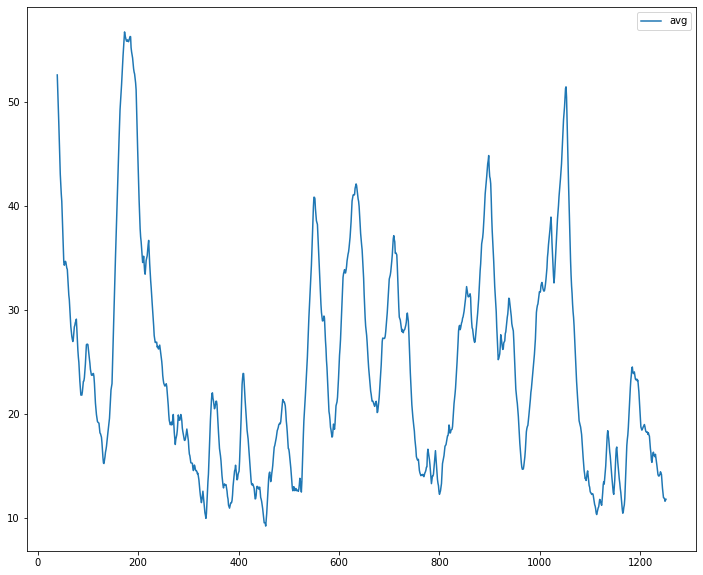

In [28]:
df['avg'] = ta.ADX(df['High'],df['Low'], df['Close'], timeperiod=20)
df[['avg']].plot(figsize=(12,10))